In [45]:
struct Var # so I don't need autohash equals?
    x::Symbol # or should this be a gensym symbol?
end


function walk(s,u) # ImmutableDict is linked list? Pretty generic actually.
    while isa(u,Var) && haskey(s,u)
            u = get(s,u)
    end
    return u
end

eqwal(u,v) = s -> begin
                     s = unify(u,v,s)
                     (s == nothing) ? () : (s,)
                  end


function unify(u,v,s)
    u = walk(s,u)
    v = walk(s,v)
    if isa(u,Var) && isa(v,Var) && u === v
        return s
    elseif isa(u,Var)
        return assoc(s,u,v)
    elseif isa(v,Var)
        return assoc(s,v,u)
    elseif isa(u, Expr) && isa(v,Expr)
        @assert u.head === :call && v.head === :call  # not supporting arbitrary expressions. Only nested function calls basically.
        if u.args[1] === v.args[1] && length(u.args) == length(v.args) #heads match
            for (u,v) in zip( u.args[2:end] , v.args[2:end] ) 
                s = unify(u,v,s)
                if s === nothing
                    return nothing
                end
            end
            return s
            #[  unify(u,v,s)  for (u,v) in zip( u.args[2:end] , v.args[2:end] ) ]
        else
            return nothing # return nothing is
        end
    else
        if u === v
            return s
        else
            return nothing
        end
    end
end
#=
function unify(u::Expr, v::Expr, s)
    @assert u.head === :call && v.head === :call  # not supporting arbitrary expressions. Only nested function calls basically.
    println(u,v)
    if u.args[1] === v.args[1] && length(u.args) == length(v.args) #heads match
        for (u,v) in zip( u.args[2:end] , v.args[2:end] ) 
            s = unify(u,v,s)
            if s === nothing
                return nothing
            end
        end
        return s
        #[  unify(u,v,s)  for (u,v) in zip( u.args[2:end] , v.args[2:end] ) ]
    else
        return nothing # return nothing is
    end
end

unify(x::Var,y::Var,s) = begin x = walk(s,x); y = walk(s,y); (x === y) ? s : assoc(s, x, y) end
unify(x::Var,y,s) = begin @assert(!isa(y,Var)); x = walk(s,x); y = walk(s,y); assoc(s, x, y) end
unify(x,y::Var,s) =  begin @assert(!isa(x,Var)); x = walk(s,x); y = walk(s,y); assoc(s, y, x) end
# default case. Symbol, integer, string. Is this a bad idea to leave this open?
unify(x::Symbol,y::Symbol,s) = (x === y) ? s : nothing
unify(x::Expr,y::Symbol,s) = nothing
unify(x::Symbol,y::Expr,s) = nothing

=#
fresh(f) = f(Var(gensym()))
fresh2(f) = f(Var(gensym()), Var(gensym()))
fresh3(f) = f(Var(gensym()), Var(gensym()), Var(gensym()))
freshn(n, f) = f([Var(gensym()) for i in 1:n ]...) # fishy lookin, but works. Not so obvious the evaluation order here.



# simpler version
disj(g1,g2) = s -> Iterators.flatten(  (g1(s)  , g2(s)) ) # conctenate them
# bind = "flatmap". flatten ~ join
#conj(g1,g2) = s -> Iterators.flatten( map( g2 ,  g1(s) )) # eta expansion

#=
disj(g1,g2) = s -> begin
     s1 = g1(s)
     s2 = g2(s)
     if isa(s1,Function)
        () -> disj(s2, s1())
     else
        Iterators.flatten(  (s1  , s2) )
     end
end
      # conctenate them
#disj(g1::Function,g2) = () -> disj(g2, g1()) # is thunking even necessary? iterators are already lazy. I think it kind of might be?
conj(g1,g2) = s ->  begin
                        q = g1(s)
                        if isa(g1(s),Function)
                            () -> conj(q(), g2)
                        else
                            Iterators.flatten( map( g2 ,  q )) # eta expansion
                        end
                    end

=#

# yeah this isn't right. mplus recursively calls mplus, but here I just flatten.
#=
disj(g1,g2) = s -> begin
     s1 = g1(s)
     s2 = g2(s)
     if isa(s1,Thunk)  && !s1.forced #s1.forced == false  
        Thunk(() -> Iterators.flatten(  (s2  , force(s1)) )) # Iterators.flatten(  (s2  , force(s1))
     else
        Iterators.flatten(  (s1  , s2) )
     end
end


function mplus(s1,s2)
     if isa(s1,Thunk)  && !s1.forced #s1.forced == false  
        Thunk(() -> Iterators.flatten(  (s2  , force(s1)) )) # Iterators.flatten(  (s2  , force(s1))
     else
        Iterators.flatten(  (s1  , s2) )
     end
=#
      # conctenate them
#disj(g1::Function,g2) = () -> disj(g2, g1()) # is thunking even necessary? iterators are already lazy. I think it kind of might be?
conj(g1,g2) = s -> Iterators.flatten( map( g2 ,  g1(s) )) # eta expansion
#=
macro Zzz(g) # does this have to be a macro? Is there a benefit? Yes. For evaluation order. We don't want g evaluated before being passed
    return :(s -> () -> $g(s))
end
=#

macro Zzz(g) # does this have to be a macro? Is there a benefit? Yes. For evaluation order.
    return :(s -> Thunk(() -> $(esc(g))(s)))
end

# hmm. Maybe these too?
conjplus(g) = @Zzz(g)
conjplus(g0,gs...) = conj(@Zzz(g0), conjplus(gs...))

disjplus(g) = @Zzz(g)
disjplus(g0,gs...) = disj(@Zzz(g0), disjplus(gs...))

conde(clauses) = disjplus(map(conjplus, clauses))

# nice operator forms
∧ = conj # \wedge
∨ = disj # \vee
≅ = eqwal #\cong





using FunctionalCollections
#run(c) = c( @Persistent Dict() )

function call_empty(n::Int64, c)
    collect(Iterators.take(c( @Persistent Dict() ), n))
end

#=
FunctionalCollections.assoc(s::Base.ImmutableDict, u,v) = Base.ImmutableDict(s,u,v)
function call_empty(n::Int64, c)
    collect(Iterators.take(c( Base.ImmutableDict{Var,Union{Expr,Var,Symbol}}() ), n))
end
=#

function run(n, f)
    q = Var(gensym())
    res = call_empty(n, f(q))
    return map(s -> walk_star(q,s), res)    
end

function walk_star(v,s)
        v = walk(s,v)
        if isa(v,Var)
            return v
        elseif isa(v,Expr)
            @assert v.head == :call
            return Expr(v.head ,vcat( v.args[1], map(v -> walk_star(v,s), v.args[2:end]))...)
        else
            return v
        end
end

#=   s = pull(c( @Persistent Dict() ))
   n, state = iterate(s)
   println(n)
   while n >= 0 && state !== nothing
       s = pull(s)
       iterate(,state)     
       n = n - 1
   end
=#


# Where do these get forced. Not obvious. Do they get forced when flattened? 
mutable struct Thunk #{I}
   it # Union{I,Function}
   forced::Bool
end

# The older style wasn't good in that it relied on the hting being thunked to not be function
Thunk(x) = Thunk(x,false)
#= function pull(x) # Runs the trampoline
    while isa(x,Function)
        x = x()
    end
    x
end
=#


function force(x::Thunk)
    if !x.forced
        x.forced = true
        x.it = x.it()
    end
end
#=
function Base.length(x::Thunk) 
    #x.it = pull(x.it)
    force(x)
    Base.length(x.it)
end
=#

Base.IteratorSize(::Type{Thunk}) = Base.SizeUnknown()


function Base.iterate(x::Thunk) 
    #x.it = pull(x.it)
    force(x)
    Base.iterate(x.it)
end

function Base.iterate(x::Thunk, state) 
    #x.it = pull(x.it) # Should we assume forced?
    force(x)
    Base.iterate(x.it, state)
end



In [18]:
thunkn(n) = Thunk(() -> begin print(n) ; (n,) end )

i = Iterators.flatten(( thunkn(1), thunkn(2)))

for j in i
    print("ff")
end

for j in i
    print("ff")
end



1ff2ffffff

In [6]:
print_subo = s -> begin println(s); (s,) end

#125 (generic function with 1 method)

In [7]:
printo(v) = s -> begin println(walk_star(v,s)); (s,) end

printo (generic function with 1 method)

In [4]:
# fresh macro could easily count the number of arguments
function nat(n)
    s = :zero
    for i in 1:n
        s = :(succ($s))
    end
    return s
end

nat (generic function with 1 method)

In [12]:
# What the hell is this and why did i need it?
Iterators.flatten_iteratorsize(::Union{Base.HasLength, Base.HasShape}, ::Type{Union{}}) = Base.SizeUnknown()

In [47]:
using Profile


In [48]:
function typo(f,t)
    fresh(a -> (f ≅ :(id($a))) ∧ (t  ≅ :(Hom($a,$a)))) ∨
    fresh2( (a,b) -> (f ≅ :fst) ∧ (t  ≅ :(Hom(tup($a,$b),$a)))) ∨
    fresh2( (a,b) -> (f ≅ :snd) ∧ (t  ≅ :(Hom(tup($a,$b),$b)))) ∨
    @Zzz(freshn( 5, (g,h,a,b,c) -> (f ≅ :(comp($g, $h)))  ∧ (t  ≅ :(Hom($a,$c))) ∧ typo(g, :(Hom($a,$b)))  ∧ typo(h, :(Hom($b,$c))))) #∨
end

function typo(f, t, n)
    fresh2( (a,b) -> (f ≅ :fst) ∧ (t  ≅ :(Hom(tup($a,$b),$a)))) ∨
    fresh2( (a,b) -> (f ≅ :snd) ∧ (t  ≅ :(Hom(tup($a,$b),$b)))) ∨
    freshn( 6, (g,h,a,b,c,n2) -> #= printo(n) ∧ =# (n ≅ :(succ($n2))) ∧ (f ≅ :(comp($g, $h)))  ∧ (t  ≅ :(Hom($a,$c))) ∧ @Zzz(typo(g, :(Hom($a,$b)), n2))  ∧ @Zzz(typo(h, :(Hom($b,$c)), n2))) #∨
    #fresh(a -> (f ≅ :(id($a))) ∧ (t  ≅ :(Hom($a,$a))))
end

run(1,  f ->  typo( f  , :(Hom(b,b))))
run(1,  f ->  typo( f  , :(Hom(tup(a,b),b))))
#call_empty(1, fresh(f ->  typo( f  , :(Hom(tup(a,tup(b,c)),a)))))
@profile run(1, f ->  typo( f  , :(Hom(tup(a,tup(b,tup(c,d))),d)), nat(5)))
# fresh( n -> nato(n) ∧ type(f, q, n) ) # iterative deepening search
#run(1, f ->  typo( f  , :(Hom(tup(a,tup(b,c)),b))))


#run(6,  fb ->  fresh2( (f,a) ->  ( :(tup($f, $a)) ≅ fb ) ∧ typo( f   , :(Hom($a,b)), nat(3))))
# limit stack depth


1-element Array{Expr,1}:
 :(comp(snd, comp(snd, snd)))

In [ ]:
eqwal(u,v) = (s.cb) -> begin
                       s = unify(u,v,s)
                       (s == nothing) ? puts!(() : (s,)
                       end

In [2]:
c = Channel(1)
put!(c,"fred")
close(c)
try
    println(take!(c))
    println(take!(c))
    
catch e
      println("caught error $e")
end

hey
hey
fred
caught error InvalidStateException("Channel is closed.", :closed)


In [10]:
c = Channel()

function producer(c)
    for i in 1:10
        put!(c,i)
    end
end
@async producer(c)

@async for j in 1:11
    try
        i = take!(c)
        println(i)
    catch e
        println(e)
    end
end
#lose(c)   

        



1


Task (runnable) @0x00007f4bbba47820

2
3
4
5
6
7
8
9
10


In [ ]:

# https://esimmler.com/building-canrun-part-1/ Canrun, a rust logic programming


function bind(s,f)
    retc -> 
        c = Channel()
        @async s(c)
        for i in c
            @async f(i)(retc)
        end
end


# a stream in this representation is  c -> (), where c is a channel that support put, so Stream{a} = Chan{a} -> () = (a -> ()) -> ()
# (exists c, c -> a -> () ) -> ()  packing together Chan and put. We can also close and take
# pure effectful computations return Nothing in julia
# (a -> Nothing) -> Nothing


# https://codon.com/hello-declarative-world


function mplus(s1,s2) 
    retc -> begin
            @async s1(retc)
            @async s2(retc)
            end
end


fromiter(iter) = c -> begin
     for i in iter
        @async put!(c,i)
    end
end


In [1]:
# where hsould the async go? around the for? Around the put
fromiter1(iter) = c -> begin
     for i in iter
        @async put!(c,i)
    end
end

fromiter2(iter) = c -> begin
     @async for i in iter
        put!(c,i)
    end
end

fromiter3(iter) = c -> begin
     for i in iter
        put!(c,i)
    end
end


# calling convetion. Are these functions going to be called in an async or not?

# fromiter3 blocks so that it doesn't spam. Seems like a fairer interleave.



fromiter3 (generic function with 1 method)

In [36]:
function mplus(s1,s2) 
    retc -> begin
            @async s1(retc)
            @async s2(retc)
            end
end

function mplus(s1,s2) 
    retc -> begin
            c = Channel()
            @async s1(retc)
            @async s2(retc)
            for i in c
               put!(retc,i)
            end
end

function mbind(s,f)
    retc -> begin
        c = Channel()
        @async s(c) # t = 
            # bind(c,t)
        for i in c
            @async f(i)(retc)
        end
    end
end

munit(z) = c -> put!(c,z) # @async put!(c,z)

munit (generic function with 1 method)

In [16]:
runchan(f) = begin
      c = Channel() 
      @async f(c)
      #t = @async f(c)
      #bind(c,t)
      @async begin sleep(2); close(c) end
      return c
end



runchan (generic function with 1 method)

Blocking isn't bad persay. We want blocking to keep things from getting out of control. Maybe the only place we want to not block is mplus


put is very similar to yield.
take is returning 


creating a new channel is ~ delimitted continuation?


# to stall.
put!(c, ())
# 

for x in c
    if  !isa(x,Tuple{})
    println(x)
    end
    end



The logict paper is not at all what i remember it being about. Interleave is a side point
The msplit abstraction I guess is the main point. And it really is about monad transformers


In [ ]:
# to stall.
put!(c, ())

#sleep = c -> put!(c,()) = munit(())
# But we have to sleep on the main threade.

@async for x in c
    if  !isa(x,Tuple{})
        println(x)
    end
end
# close c later at your leisure


In [26]:
for x in runchan(mbind(fromiter1(1:4), z -> c -> put!(c,z)))
    println(x)
end

LoadError: UndefVarError: c not defined

In [20]:
for x in runchan(mplus(fromiter3(30:34),fromiter3(1:10)))
    println(x)
end

30
1
31
2
32
3
33
4
34
5
6
7
8
9
10


In [46]:
c = Channel(fromiter3(1:10))
for i in c 
    println(i)
end


1
2
3
4
5
6
7
8
9
10


In [30]:
for x in runchan(mplus(munit(7), munit(4)))
    println(x)
end

7
4


In [35]:
for x in runchan(mbind(munit(7), munit))
    println(x)
end

77


In [13]:
typeof(print("hello"))

hello

Nothing

In [11]:
close(c)

InvalidStateException("Channel is closed.", :closed)


In [45]:
c = Channel(3)
@async put!(c,1)
@async put!(c,2)

@async for i in c
    println(i)
end
sleep(1)
close(c)

1
2


In [ ]:

#function eqwal2(s, u,v, cb)
    @async cb( unify(s,u,v) )
end

I guess we could puts everything into an out channel
Out channels are a lot like continuations


function eqwal2(s,u,v,out)
    puts!( unify(s,u,v), out)

function disj(g1,g2)
    (s,c) -> begin @async  g1(s,c)
                    @async g2(s,c)
             end

function conj(g1,g2)
    (s,c1) -> begin
                c2 = Channel()
                @async g1(s,c)
                map(s -> @async(g2(s,c1)), c2)
             end
end

        # conversion fromiterator to channel 
for i in ss
    put!(c,i)
end
        
        


In [50]:
using ProfileVega

┌ Info: Precompiling ProfileVega [4391764f-db79-4bd7-a4c6-f9062de4300e]
└ @ Base loading.jl:1278


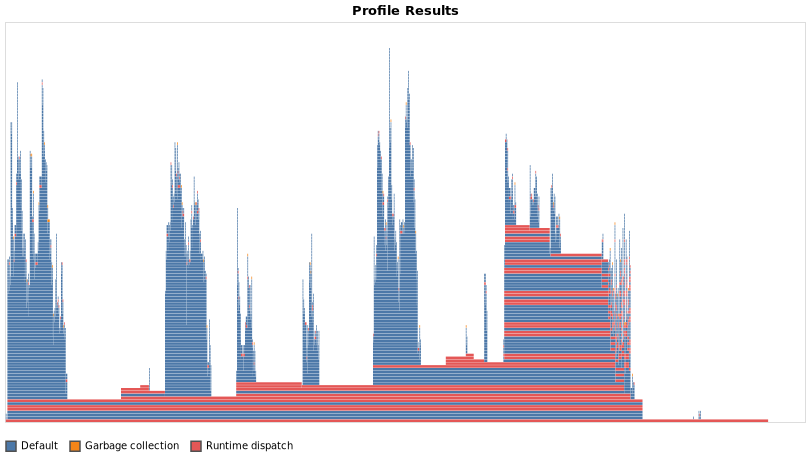

In [51]:
ProfileVega.view()

In [34]:
typeof(nothing)

Nothing

In [25]:
iter =      (fb ->  fresh2( (f,a) ->  ( :(tup($f, $a)) ≅ fb ) ∧ typo( f   , :(Hom($a,b)), nat(3))))(Var(gensym()))(@Persistent Dict() )
v, s = iterate(iter)
for x in 1:3
    v, s = iterate(iter, s)
    print(v)
end


PersistentHashMap{Any,Any}(Var(Symbol("##115016")) => :(tup(Var(Symbol("##115018")), Var(Symbol("##115019")))),Var(Symbol("##115018")) => :b,Var(Symbol("##115015")) => :fst,Var(Symbol("##115014")) => :(tup(Var(Symbol("##115015")), Var(Symbol("##115016")))))PersistentHashMap{Any,Any}(Var(Symbol("##115016")) => :(tup(Var(Symbol("##115020")), Var(Symbol("##115021")))),Var(Symbol("##115015")) => :snd,Var(Symbol("##115014")) => :(tup(Var(Symbol("##115015")), Var(Symbol("##115016")))),Var(Symbol("##115021")) => :b)

LoadError: MethodError: flatten_iteratorsize(::Base.HasShape{1}, ::Type{Union{}}) is ambiguous. Candidates:
  flatten_iteratorsize(::Union{Base.HasLength, Base.HasShape}, ::Type{var"#s91"} where var"#s91"<:Tuple{Vararg{Any,N}}) where N in Base.Iterators at iterators.jl:1043
  flatten_iteratorsize(::Union{Base.HasLength, Base.HasShape}, ::Type{var"#s91"} where var"#s91"<:Number) in Base.Iterators at iterators.jl:1045
  flatten_iteratorsize(::Union{Base.HasLength, Base.HasShape}, ::Type{var"#s91"} where var"#s91"<:Tuple) in Base.Iterators at iterators.jl:1044
Possible fix, define
  flatten_iteratorsize(::Union{Base.HasLength, Base.HasShape}, ::Type{Union{}})

In [4]:
@macroexpand  @Zzz(freshn( 5, (g,h,a,b,c) -> (f ≅ :(comp($g, $h)))  ∧ (t  ≅ :(Hom($a,$c))) ∧ typo(g, :(Hom($a,$b)))  ∧ typo(h, :(Hom($b,$c)))))

:(var"#30#s"->begin
          #= In[1]:131 =#
          Main.Thunk((()->begin
                      #= In[1]:131 =#
                      (freshn(5, ((g, h, a, b, c)->begin
                                  #= In[4]:1 =#
                                  (((f ≅ Core._expr(:call, :comp, g, h)) ∧ (t ≅ Core._expr(:call, :Hom, a, c))) ∧ typo(g, Core._expr(:call, :Hom, a, b))) ∧ typo(h, Core._expr(:call, :Hom, b, c))
                              end)))(var"#30#s")
                  end))
      end)

In [ ]:
struct Goal
    it
end

(x::Goal)(zs...) = x.it(zs...)

In [48]:
 Base.operator_precedence(:*),  Base.operator_precedence(:+), Base.operator_precedence(:^)

(12, 11, 15)

In [49]:
#Base.:*(x::Goal, y::Goal) = x ∧ y
#Base.:+(x::Goal, y::Goal) = x ∨ y
#Base.:^(x::Goal, y::Goal) = x ≅ y
^ = ≅

eqwal (generic function with 1 method)

In [54]:
function pluso(x,y,z)
       (x ^ :zero  ∧  y ^ z) ∨
       (fresh2( (n,m) -> x ^ :(succ($n)) ∧ z ^ :(succ($m)) ∧ @Zzz(pluso( n, y, m) )))
end

pluso (generic function with 1 method)

In [57]:
function appendo(x,y,z)
    (x ≅ :nil) ∧ (y ≅ z) ∨
    fresh3( (hd, xs ,zs) ->  (x ≅ :(cons($hd,$xs)) )  ∧ (z ≅ :(cons($hd, $zs)))  ∧ @Zzz( appendo( xs,y,zs )))
end

appendo (generic function with 1 method)

In [79]:
run(3, q ->  appendo(   :(cons(3,nil)), :(cons(4,nil)), q )  )

1-element Array{Expr,1}:
 :(cons(3, cons(4, nil)))

In [62]:
run(3, q ->  appendo(   q, :(cons(4,nil)), :(cons(3, cons(4, nil))) )  )

1-element Array{Expr,1}:
 :(cons(3, nil))

In [75]:
run(10, q -> fresh2( (x,y) ->  (q ≅ :(tup($x,$y))) ∧ appendo( x, y, :(cons(3,cons(4,nil)))  )))

3-element Array{Expr,1}:
 :(tup(nil, cons(3, cons(4, nil))))
 :(tup(cons(3, nil), cons(4, nil)))
 :(tup(cons(3, cons(4, nil)), nil))

In [72]:
call_empty(1, fresh(q -> appendo( :nil, q, :(cons(3,$q)) ) ))

1-element Array{Any,1}:
 Persistent{Any, Any}[Var(Symbol("##418")) => cons(3, Var(Symbol("##418")))]

In [46]:
Base.operator_precedence(:&), Base.operator_precedence(:|) , Base.operator_precedence(:^)

(12, 11, 15)

In [45]:
Base.operator_precedence(:∧),Base.operator_precedence(:∨) ,Base.operator_precedence(:≅) # The operator precendce is the opposite I would've wanted...

(12, 11, 7)

In [ ]:
Base.operator_precedence(∧),Base.operator_precedence(∨) ,Base.operator_precedence(≅)

In [80]:
function nat(n)
    s = :zero
    for i in 1:n
        s = :(succ($s))
    end
    return s
end

function pluso(x,y,z)
      (( x ≅ :zero ) ∧ (y ≅ z) ) ∨
      fresh2( (n,m) -> (x ≅ :(succ($n))) ∧ (z ≅ :(succ($m))) ∧ @Zzz(pluso( n, y, m)))
end

pluso (generic function with 1 method)

In [82]:
run(5, z -> pluso(nat(2), nat(2), z))

1-element Array{Expr,1}:
 :(succ(succ(succ(succ(zero)))))

In [3]:
isa(Var(gensym()), Symbol)

false

In [6]:
run(5, (z -> pluso(:(succ(zero)), :(succ(zero)), z))(Var(gensym("z")))   )

1-element Array{Any,1}:
 Persistent{Any, Any}[Var(Symbol("##257")) => succ(zero), Var(Symbol("##256")) => zero, Var(Symbol("##z#255")) => succ(Var(Symbol("##257")))]

In [36]:
run(5, z -> fresh2( (x,y) -> (z ≅ :( tup($x , $y))) ∧ pluso(x, :(succ(zero)), y)))

5-element Array{Expr,1}:
 :(tup(zero, succ(zero)))
 :(tup(succ(zero), succ(succ(zero))))
 :(tup(succ(succ(zero)), succ(succ(succ(zero)))))
 :(tup(succ(succ(succ(zero))), succ(succ(succ(succ(zero))))))
 :(tup(succ(succ(succ(succ(zero)))), succ(succ(succ(succ(succ(zero)))))))

In [8]:
@macroexpand @Zzz(s ≅ :zero)

:(var"#35#s"->begin
          #= In[2]:130 =#
          Main.Thunk((()->begin
                      #= In[2]:130 =#
                      (s ≅ :zero)(var"#35#s")
                  end))
      end)

pluso (generic function with 1 method)

Is s an iterator, a iterator state, or iterator value?
No we're wo0rking mondaically. s is a value
But then we produce an iterator.

It's an iterator value.


In [5]:
Base.tail((1,2,3))

(2, 3)

In [2]:
mutable struct Thunk
   it
end
# First iterate evaluates the underlying iterator enough to know what it is.
# Then subsequently it's carried in the state?
#Thunk(x::Function) = Thunk(x,false)

# Hmm. Rather maybe we should pull.
# x.it = pull(x.it)
#=
    if !x.forced
        x.it = x.it()
        x.forced = true
    end
=#

function pull(x) # Runs the trampoline
    while isa(x,Function)
        x = x()
    end
    x
end

function Base.length(x::Thunk) 
    x.it = pull(x.it)
    Base.length(x.it)
end

function Base.iterate(x::Thunk) 
    x.it = pull(x.it)
    Base.iterate(x.it)
end

function Base.iterate(x::Thunk, state) # assume forced?
    x.it = pull(x.it)
    Base.iterate(x.it, state)
end

In [4]:
q = Thunk([1,2,3])
for x in q
    println(x)
end
for x in q
    println(x)
end

1
2
3
1
2
3


In [52]:
struct Thunk
   it
end
# First iterate evaluates the underlying iterator enough to know what it is.
# Then subsequently it's carried in the state?



function Base.iterate(x::Thunk) 
    q = x.it()
    s = Base.iterate(q)
    s === nothing && return nothing
    s[1], (q, s[2])
end

function Base.iterate(x::Thunk, state) 
    s = Base.iterate(state[1] , state[2])
    s === nothing && return nothing
    s[1], (state[1], s[2])
end

@Zzz (macro with 1 method)

In [53]:
Base.iterate([1,2,3])

(1, 2)

In [54]:
Base.tail((1,2,3))

(2, 3)

In [1]:
Base.iterate([1,2,3])

(1, 2)

In [18]:
@macroexpand( @Zzz(nato(:zero)) )

:(var"#30#s"->begin
          #= In[17]:94 =#
          Main.Thunk((()->begin
                      #= In[17]:94 =#
                      (nato(:zero))(var"#30#s")
                  end))
      end)

In [4]:
function pluso(x,y,z)
      (( x ≅ :zero ) ∧ (y ≅ z) ) ∨ fresh2( (n,m) -> (x ≅ :(succ($n))) ∧ (z ≅ :(succ($m))) ∧ @Zzz(pluso( n, y, m)))
end

pluso (generic function with 1 method)

In [18]:
@macroexpand @Zzz(pluso( n, y, m))

:(var"#16#s"->begin
          #= In[5]:94 =#
          Main.Thunk((()->begin
                      #= In[5]:94 =#
                      (pluso(n, y, m))(var"#16#s")
                  end))
      end)

In [11]:
run(5, (z -> pluso(:(succ(zero)), :zero, z))(Var(gensym("z")))   )

Var(Symbol("##z#282"))succ(Var(Symbol("##284")))
Var(Symbol("##283"))zero
Var(Symbol("##283"))succ(Var(Symbol("##285")))
Var(Symbol("##284"))succ(Var(Symbol("##286")))
Var(Symbol("##285"))zero
Var(Symbol("##285"))succ(Var(Symbol("##287")))
Var(Symbol("##286"))succ(Var(Symbol("##288")))
Var(Symbol("##287"))zero
Var(Symbol("##287"))succ(Var(Symbol("##289")))
Var(Symbol("##288"))succ(Var(Symbol("##290")))
Var(Symbol("##289"))zero
Var(Symbol("##289"))succ(Var(Symbol("##291")))
Var(Symbol("##290"))succ(Var(Symbol("##292")))
Var(Symbol("##291"))zero
Var(Symbol("##291"))succ(Var(Symbol("##293")))
Var(Symbol("##292"))succ(Var(Symbol("##294")))


5-element Array{Any,1}:
 Persistent{Any, Any}[Var(Symbol("##z#282")) => succ(Var(Symbol("##284"))), Var(Symbol("##284")) => zero, Var(Symbol("##283")) => zero]
 Persistent{Any, Any}[Var(Symbol("##285")) => zero, Var(Symbol("##z#282")) => succ(Var(Symbol("##284"))), Var(Symbol("##284")) => succ(Var(Symbol("##286"))), Var(Symbol("##283")) => succ(Var(Symbol("##285"))), Var(Symbol("##286")) => zero]
 Persistent{Any, Any}[Var(Symbol("##285")) => succ(Var(Symbol("##287"))), Var(Symbol("##287")) => zero, Var(Symbol("##z#282")) => succ(Var(Symbol("##284"))), Var(Symbol("##284")) => succ(Var(Symbol("##286"))), Var(Symbol("##283")) => succ(Var(Symbol("##285"))), Var(Symbol("##288")) => zero, Var(Symbol("##286")) => succ(Var(Symbol("##288")))]
 Persistent{Any, Any}[Var(Symbol("##285")) => succ(Var(Symbol("##287"))), Var(Symbol("##287")) => succ(Var(Symbol("##289"))), Var(Symbol("##290")) => zero, Var(Symbol("##289")) => zero, Var(Symbol("##z#282")) => succ(Var(Symbol("##284"))), Var(Symbol("##28

In [21]:
function nato(z)
    (z ≅ :zero) ∨ (fresh( n -> (z ≅ :(succ($n))) ∧ @Zzz(nato(n)) ))
end

nato (generic function with 1 method)

In [24]:
run(5, fresh(q -> nato(q)))

5-element Array{PersistentHashMap{Any,Any},1}:
 Persistent{Any, Any}[Var(Symbol("##267")) => zero]
 Persistent{Any, Any}[Var(Symbol("##267")) => succ(Var(Symbol("##268"))), Var(Symbol("##268")) => zero]
 Persistent{Any, Any}[Var(Symbol("##267")) => succ(Var(Symbol("##268"))), Var(Symbol("##269")) => zero, Var(Symbol("##268")) => succ(Var(Symbol("##269")))]
 Persistent{Any, Any}[Var(Symbol("##267")) => succ(Var(Symbol("##268"))), Var(Symbol("##269")) => succ(Var(Symbol("##270"))), Var(Symbol("##270")) => zero, Var(Symbol("##268")) => succ(Var(Symbol("##269")))]
 Persistent{Any, Any}[Var(Symbol("##271")) => zero, Var(Symbol("##267")) => succ(Var(Symbol("##268"))), Var(Symbol("##269")) => succ(Var(Symbol("##270"))), Var(Symbol("##270")) => succ(Var(Symbol("##271"))), Var(Symbol("##268")) => succ(Var(Symbol("##269")))]

In [67]:
isa((3,), Tuple{T})

LoadError: UndefVarError: T not defined

In [29]:
function twoo(r)
    (r ≅ :zero) ∨ @Zzz(r ≅ :(succ(zero))) #∨ (z ≅ :(succ(succ(zero))))
end

twoo (generic function with 1 method)

In [28]:
@macroexpand r -> @Zzz(r)

:(r->begin
          #= In[28]:1 =#
          var"#44#s"->begin
                  #= In[26]:89 =#
                  ()->begin
                          #= In[26]:89 =#
                          Main.r(var"#44#s")
                      end
              end
      end)

In [28]:
nato(:zero)
#@code_llvm (:zero ≅ :zero)

#56 (generic function with 1 method)

In [31]:
g = begin
    println("hi!")
    x -> @show x
    end

hi!


#90 (generic function with 1 method)

In [39]:

macro Zzz(g)
    return :(s -> () -> $(esc(g))(s))
end
ff = @Zzz( begin println("hey"); x -> @show x end )
ff33 = ff(33)
ff33()

#123 (generic function with 1 method)

In [16]:
struct TakePull{I}
    xs::I
    n::Int
    function TakePull(xs::I, n::Integer) where {I}
        n < 0 && throw(ArgumentError("Take length must be nonnegative"))
        return new{I}(xs, n)
    end
end

takepull(xs, n::Integer) = TakePull(xs, Int(n))
takepull(xs::TakePull, n::Integer) = TakePull(xs.xs, min(Int(n), xs.n))


length(t::TakePull) = _min_length(t.xs, 1:t.n, IteratorSize(t.xs), HasLength())

function Base.iterate(it::TakePull, state=(it.n,))
    n, rest = state[1], pull(Base.tail(state))
    n <= 0 && return nothing
    y = iterate(it.xs, rest...)
    y === nothing && return nothing
    return y[1], (n - 1, y[2])
end


In [32]:
#run(fresh(z -> nato(z)))

Base.Iterators.Flatten{Tuple{Tuple{PersistentHashMap{Any,Any}},Base.Iterators.Flatten{Tuple{var"#76#79"{PersistentHashMap{Any,Any}}}}}}(((PersistentHashMap{Any,Any}(Var(Symbol("##84926")) => :zero),), Base.Iterators.Flatten{Tuple{var"#76#79"{PersistentHashMap{Any,Any}}}}((var"#76#79"{PersistentHashMap{Any,Any}}(PersistentHashMap{Any,Any}(Var(Symbol("##84926")) => :(succ(Var(Symbol("##84927")))))),))))

In [30]:
run(5, fresh(q -> twoo(q)))

2-element Array{PersistentHashMap{Any,Any},1}:
 Persistent{Any, Any}[Var(Symbol("##298")) => zero]
 Persistent{Any, Any}[Var(Symbol("##298")) => succ(zero)]

In [24]:
run(5, fresh(z -> @Zzz(:(succ(succ(zero))) ≅ :(succ($z)))))

1-element Array{Any,1}:
 Persistent{Any, Any}[Var(Symbol("##294")) => succ(zero)]

In [13]:
collect(Iterators.take(@Zzz(:zero ≅ :zero)(@Persistent Dict()), 1))

1-element Array{Any,1}:
 Persistent{Any, Any}[]



Iterator.product ~ bind?
vcat ~ mplus


http://webyrd.net/scheme-2013/papers/HemannMuKanren2013.pdf




async might be a nice way to implement this stuff


Interleave is the first way of being more fair



In [ ]:
struct InterLeave{A,B}
    m::A
    n::B
    which::Bool 
    
end

function iterate( x::Interleave{A,B}) = 
   x.which = !x.which
   if x.which
     return iterate(x.m) 
   else
     return iterate(x.n)
    
function iterate(x::Chain) 
    if x.done
       return iterate(n)
            end
            return iterate(n)
end


struct Thunk
    m
end
        
flatten is join
        [x] is return
        
        
        


In [24]:
t = Task(() -> print("hi"))
schedule(t)

hi

Task (done) @0x00007fd5ec290010

In [22]:
for x in [3]
    print(x)
end

3

In [21]:
tail([1,2,3,4])

LoadError: MethodError: no method matching tail(::Array{Int64,1})
Closest candidates are:
  tail(!Matched::EmptyList) at /home/philip/.julia/packages/FunctionalCollections/1e7f3/src/PersistentList.jl:23
  tail(!Matched::PersistentList) at /home/philip/.julia/packages/FunctionalCollections/1e7f3/src/PersistentList.jl:25

In [ ]:
function interleave(m,n)
    
end

In [3]:
for i in 1:3

end

LoadError: syntax: incomplete: premature end of input

In [5]:
dump(  :( f(3,4) ) )

Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol f
    2: Int64 3
    3: Int64 4


In [7]:
function walk(u,s) # ImmutableDict is linked list
    if is_var(u)
        if haskey(s,u)
            pr = get(s,u)
            return walk(pr,s)
        end
    end
    return u
end

walk (generic function with 1 method)

In [ ]:
struct LogicState
    subst::
    counter::Int64
end

In [25]:
using FunctionalCollections
name = @Persistent Dict(:first => "Zach", :last => "Allaun")
fullname = assoc(name, :middle, "Randall") # assoc = ext-s
dissoc(fullname, :middle)
haskey(fullname,:last)

In [28]:
typeof((3,))

Tuple{Int64}

In [31]:
for x in () # you can iterate over unit which is Tuple{}
    print("hi")
end

In [35]:
typeof(:call)

Symbol

In [36]:




#=
isa(x,Var)

function unify(u,v,s)
   u = walk(s,u)
   v = walk(s,v)
   if isvar(u) && isvar(v) && u == v
      s
   end
  elseif isvar(u)
      assoc(s,u,v)
  end
  elseif isvar(v)
      assoc(s,v,u)
  end
  elseif 
      
    
elseif u == v
   return s
end
else
  return nothing
end

end
=#


LoadError: syntax: "function" at In[36]:2 expected "end", got "else"

In [1]:
struct Var # so I don't need autohash equals?
    x::Symbol # or should this be a gensym symbol?
end

In [5]:
function walk(s,u) # ImmutableDict is linked list? Pretty generic actually.
    while isa(u,Var) && haskey(s,u)
            u = get(s,u)
    end
    return u
end

# ext-s = assoc(s,x,v)



walk (generic function with 1 method)

In [19]:
eqwal(u,v) = s -> begin
     s = unify(u,v,s)
     (s == nothing) ? () : (s,)
end

eqwal (generic function with 1 method)

In [45]:
function unify(u::Expr, v::Expr, s)
    @assert u.head === :call && v.head === :call  # not supporting arbitrary expressions. Only nested function calls basically.
    if u.args[1] === v.args[1] #heads match
        for (u,v) in zip( u.args[2:end] , v.args[2:end] ) 
            s = unify(u,v,s)
            if s === nothing # early break
                return nothing
            end
        end
        return s
        #[  unify(u,v,s)  for (u,v) in zip( u.args[2:end] , v.args[2:end] ) ]
    else
        return nothing # return nothing is
    end
end



unify(x::Var,y::Var,s) = (x === y) ? s : assoc(s, x, y)

unify(x::Var,y,s) = assoc(s, x, y)
unify(x,y::Var,s) = assoc(s, y, x)

# default case. Symbol, integer, string. Is this a bad idea to leave this open?
unify(x,y,s) = (x === y) ? s : nothing

unify (generic function with 5 methods)

In [64]:
using BenchmarkTools # === is faster?
x = Var(gensym())
y = Var(gensym())
@btime x === y

  5.711 ns (0 allocations: 0 bytes)


false

In [70]:

x = :call
y = :call
@btime x === y

  4.027 ns (0 allocations: 0 bytes)


true

In [71]:
@code_llvm x == y


;  @ operators.jl:83 within `=='
define i8 @"julia_==_3534"(%jl_value_t* nonnull, %jl_value_t* nonnull) {
top:
  %2 = icmp eq %jl_value_t* %0, %1
  %3 = zext i1 %2 to i8
  ret i8 %3
}


In [76]:
@code_native ((x,y) -> x === y)(x,y)

	.text
; ┌ @ In[76]:1 within `#105'
	cmpq	%rsi, %rdi
	sete	%al
	retq
	nopw	(%rax,%rax)
; └


In [77]:
@code_native ((x,y) -> x == y)(x,y)

	.text
; ┌ @ In[77]:1 within `#107'
; │┌ @ operators.jl:83 within `=='
	cmpq	%rsi, %rdi
	sete	%al
; │└
	retq
	nopw	(%rax,%rax)
; └


In [50]:
dump(:([  1, 3,4])) # maybe we want to support this?
# or maybe anything iterable? Ehhh, I dunno

for i in :(f(1,2,3))
    print(i)
end

Expr
  head: Symbol vect
  args: Array{Any}((3,))
    1: Int64 1
    2: Int64 3
    3: Int64 4


LoadError: MethodError: no method matching iterate(::Expr)
Closest candidates are:
  iterate(!Matched::Base.RegexMatchIterator) at regex.jl:552
  iterate(!Matched::Base.RegexMatchIterator, !Matched::Any) at regex.jl:552
  iterate(!Matched::LibGit2.GitBranchIter) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/LibGit2/src/reference.jl:343
  ...

note
mzero = ()
unit(x) = (x,)

In [4]:
#callfresh(f) = s -> f(Var(gensym()))(s)
callfresh(f) = f(Var(gensym())) # eta expansion. Is this just as good? we've changed valuation order. De thunked. Uh no we haven't. f returns a thunk function


callfresh (generic function with 1 method)

In [16]:
disj(g1,g2) = s -> Iterators.flatten(  (g1(s)  , g2(s)) ) # conctenate them
#conj(g1,g2) = s -> Iterators.flatten( map( s1 -> g2(s1) ,  g1(s) )) # bind = "flatmap". flatten ~ join
conj(g1,g2) = s -> Iterators.flatten( map( g2 ,  g1(s) )) # eta expansion

conj (generic function with 1 method)

In [ ]:
struct Interleave{I}
    it::I
end

interleave(x,y) = Interleave 

@propagate_inbounds function iterate(f::Flatten, state=())
    if state !== () #
        y = iterate(tail(state)...)
        y !== nothing && return (y[1], (state[1], state[2], y[2]))
    end
    x = (state === () ? iterate(f.it) : iterate(f.it, state[1]))
    x === nothing && return nothing
    y = iterate(x[1])
    while y === nothing
         x = iterate(f.it, x[2])
         x === nothing && return nothing
         y = iterate(x[1])
    end
    return y[1], (x[2], x[1], y[2])
end


In [ ]:
@enum InterleaveState = Arun, A, B, Adone, Bdone

struct Interleave{I1,I2}
    a::I1
    b::I2
end

interleave(x,y) = Interleave(x,y)

function iterate( f::Interleave, state=())
    if state === ()
        x = iterate(f.a)
        if x === nothing
            x = iterate(f.b)
            if x === nothing
                return nothing
            else
                return x[1], (Adone, x[2])
        end
        return x, (Arun, xstate) 
    elseif state[1] == Arun
        x = iterate(f.b)
        if x === nothing
            x = iterate(f.a)
            if x === nothing
                return nothing
            else
                return x[1], (Bdone, x[2])   
            
        end
        return x[1], (A, state[2], x[2])
    elseif state[1] == A
        
    
end



In [54]:
methods(tail)

# 2 methods for generic function "tail":
[1] tail(::EmptyList) in FunctionalCollections at /home/philip/.julia/packages/FunctionalCollections/1e7f3/src/PersistentList.jl:23
[2] tail(l::PersistentList) in FunctionalCollections at /home/philip/.julia/packages/FunctionalCollections/1e7f3/src/PersistentList.jl:25

In [36]:
using FunctionalCollections
run(c) = c( @Persistent Dict() )
run(n::Int64, c) = collect(Iterators.take(c( @Persistent Dict() ), n))

run (generic function with 2 methods)

In [40]:
run(2,callfresh( x -> callfresh(y -> disj(eqwal(x,x), eqwal(x,y)) )))

2-element Array{PersistentHashMap{Any,Any},1}:
 Persistent{Any, Any}[]
 Persistent{Any, Any}[Var(Symbol("##282")) => Var(Symbol("##283"))]

In [43]:
run(2,callfresh( x -> 
      callfresh( y ->     
            eqwal( :(f($x, $x)) , :(f($y, $x)) ) 
            )))

1-element Array{PersistentHashMap{Any,Any},1}:
 Persistent{Any, Any}[Var(Symbol("##288")) => Var(Symbol("##289"))]

In [141]:
function Zzz(g) # does this have to be a macro? Is there a benefit?
    s -> () -> g(s)
end

conjplus(g) = Zzz(g)
conjplus(g0,gs...) = conj2(Zzz(g0), conjplus(gs...))

disjplus(g) = Zzz(g)
disjplus(g0,gs...) = disj2(Zzz(g0), disjplus(gs...))


conde(clauses) = disjplus(map(conjplus, clauses))

#ok fresh does need to be a macro?
#fresh( ) = 

# fresh(x,y,z, eqwal(x,y)   )



conde (generic function with 1 method)

In [129]:
fresh(f) = f(Var(gensym()))
fresh2(f) = f(Var(gensym()), Var(gensym()))
fresh3(f) = f(Var(gensym()), Var(gensym()), Var(gensym()))
freshn(n, f) = f([Var(gensym()) for i in 1:n ]...) # fishy lookin. Not so obvious the evaluation order here.
# freshstar(f) = f([Var(gensym()) for i in  ]...) # I'm not sure this is possible or desirable. Splat might be eager

freshn (generic function with 2 methods)

In [121]:
run(freshn(5, (x,y,z,w) -> x ≅ y))

LoadError: MethodError: no method matching (::var"#137#138")(::Var, ::Var, ::Var, ::Var, ::Var)
Closest candidates are:
  #137(::Any, ::Any, ::Any, ::Any) at In[121]:1

In [126]:
collect(Iterators.take(Iterators.repeated(Var(gensym())),10))

10-element Array{Var,1}:
 Var(Symbol("##424"))
 Var(Symbol("##424"))
 Var(Symbol("##424"))
 Var(Symbol("##424"))
 Var(Symbol("##424"))
 Var(Symbol("##424"))
 Var(Symbol("##424"))
 Var(Symbol("##424"))
 Var(Symbol("##424"))
 Var(Symbol("##424"))

In [128]:
[Var(gensym()) for i in 1:3 ]

3-element Array{Var,1}:
 Var(Symbol("##425"))
 Var(Symbol("##426"))
 Var(Symbol("##427"))

In [107]:
# macro is only marginally better

macro fresh(x,e)
    println(x)
    println(e)
    return Expr(:call, [:callfresh, Expr(:->, x, e )])
end

@fresh (macro with 1 method)

In [108]:
@macroexpand @fresh(x, x ≅ x)

x
x ≅ x


:((Any[:callfresh, :(x->x ≅ x)])())

More sophisticatede search control

We may want some kind of heuristic or beam strategy put in there.
To do so we'd want to inspect the stream state.



There is thunking of goals and streams. Goals are stream transformers.






In [98]:
dump(quote (x -> z) end)

Expr
  head: Symbol block
  args: Array{Any}((2,))
    1: LineNumberNode
      line: Int64 1
      file: Symbol In[98]
    2: Expr
      head: Symbol ->
      args: Array{Any}((2,))
        1: Symbol x
        2: Expr
          head: Symbol block
          args: Array{Any}((2,))
            1: LineNumberNode
              line: Int64 1
              file: Symbol In[98]
            2: Symbol z


In [79]:
methods(≡)

# built-in function; no methods

In [80]:
3 ≡ 4

false

In [88]:
#methods(Π) 
methods(≅) # \cong

LoadError: UndefVarError: ≅ not defined

In [89]:
∧ = conj # \wedge
∨ = disj # \vee
≅ = eqwal

eqwal (generic function with 1 method)

In [143]:
function typo(f,t)
disjplus([ # fresh( a ->   (f ≅ :id) ∧ (t ≅ :(hom($a,$a)))),
           (f ≅ :f) ∧ (t ≅ :(hom(a,c)))
        ])
end

typo (generic function with 1 method)

In [144]:
run(fresh2(typo))

#156 (generic function with 1 method)

In [91]:
run(2,callfresh( x -> callfresh(y -> (x ≅ x) ∨ (x ≅ y) )))

2-element Array{PersistentHashMap{Any,Any},1}:
 Persistent{Any, Any}[]
 Persistent{Any, Any}[Var(Symbol("##398")) => Var(Symbol("##399"))]

In [94]:
Base.operator_precedence(:∨), Base.operator_precedence(:∧), Base.operator_precedence(:≅)

(11, 12, 7)

In [95]:
Base.operator_associativity(:∨), Base.operator_associativity(:∧), Base.operator_associativity(:≅)

(:left, :left, :none)

In [51]:
disj2(g1,g2) = s -> Iterators.flatten(  (g1(s)  , g2(s)) ) # conctenate them
disj2(g1::Function,g2) = () -> disj2(g2, g1()) # is thunking even necessary? iterators are already lazy. I think it kind of might be?
#conj(g1,g2) = s -> Iterators.flatten( map( s1 -> g2(s1) ,  g1(s) )) # bind = "flatmap". flatten ~ join
conj2(g1,g2) = s -> begin
                    q = if isa(g1(s),Function)
                    () -> conj2(q(), g2)
                    else
                    Iterators.flatten( map( g2 ,  q )) # eta expansion
                    end

conj2 (generic function with 1 method)

In [14]:
Iterators.flatten((1:4, 6:8))

Base.Iterators.Flatten{Tuple{UnitRange{Int64},UnitRange{Int64}}}((1:4, 6:8))

In [44]:
dump(:(x = 3))

Expr
  head: Symbol =
  args: Array{Any}((2,))
    1: Symbol x
    2: Int64 3


In [3]:
x = gensym()
Var(x) == Var(gensym())

false

In [ ]:
callfresh(f) = sc -> f(Var(sc.counter))(  LogicState(sc.subst, sc.counter + 1) )
disj(g1,g2) = sc -> mplus(  g1(sc)  , g2(sc)  )
conj(g1,g2) = sc -> bind( g1(sc) , g2 )

In [ ]:
mplus(s1::Nothing, s2)
mplus(s1::Task,s2) = @task mplus(schedule(s1), s2)
mplus(s1::Function,s2) = mplus(s1(), s2)
mplus(s1,s2) = chain(s1,s2)

In [ ]:
struct Thunk # a tag on an iterator suggesting that we should hold off on calling next. Is this a defunctionalized thunk?
    x
end

mplus(x::Thunk,y ) = mplus(x.x, y) 


In [47]:
isa(x -> x, Function)

true

In [ ]:
function eqwal(u,v)
    ret = sc -> s = unify(u,v,sc)
                if s != nothing
                     return (( s, sc[2] ) , ) # single tuple as iterator? I think this should work better than []?
        end 
    else
        () # empty array as ampty iterator
    end
          

end

In [51]:
dump(:(3))

Int64 3


In [41]:
typeof(nothing)

Nothing

In [53]:
dump(:(f(3,"340", Var(3))))

Expr
  head: Symbol call
  args: Array{Any}((4,))
    1: Symbol f
    2: Int64 3
    3: String "340"
    4: Expr
      head: Symbol call
      args: Array{Any}((2,))
        1: Symbol Var
        2: Int64 3


In [40]:
dump(:(f(Var(3))))

Expr
  head: Symbol call
  args: Array{Any}((2,))
    1: Symbol f
    2: Expr
      head: Symbol call
      args: Array{Any}((2,))
        1: Symbol Var
        2: Int64 3


In [33]:
map(x->x*x, 1:7)

7-element Array{Int64,1}:
  1
  4
  9
 16
 25
 36
 49

LoadError: UndefVarError: ispositive not defined

In [17]:
hd(1:3)

LoadError: UndefVarError: hd not defined

In [19]:
if nothing 
    print("foo")
end

LoadError: TypeError: non-boolean (Nothing) used in boolean context

In [20]:
(1,2)

(1, 2)